In [1]:
from pyiron_workflow import Workflow
from structure_nodes import get_structure
from thermo_potential import obtain_potential
import numpy as np
from calphy_nodes import CreateInputDict, Initialize, RunCalculation, GetResults

### Create input template

In [2]:
inp = CreateInputDict()

In [3]:
inp['temperature'] = [1000, 1100]
inp['pressure'] = 0
inp['reference_phase'] = 'solid'
inp['mode'] = 'ts'
inp['equilibration_control'] = 'berendsen'
inp['queue']['cores'] = 4	

### Workflow

In [7]:
wf = Workflow('test')
wf.step1 = obtain_potential('2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2')
wf.step2 = get_structure(species='Cu', repeat=(2,2,2))
wf.step3 = Initialize(inp, wf.step2.outputs.structure,
                     wf.step1.outputs.element_list,
                     wf.step1.outputs.files,
                     wf.step1.outputs.config)
wf.step4 = RunCalculation(wf.step3.outputs.calculation,
                         wf.step3.outputs.simfolder)
wf.step5 = GetResults(wf.step4.outputs.job)

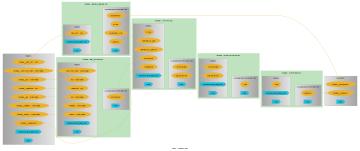

In [8]:
wf.draw(size=(5,5))

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2024-09-02/lib/python3.11/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------
[cmti001:18212] 3 more processes have sent help message help-mpi-btl-openib.txt / error in device init
[cmti001:18212] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------
[cmti001:18307] 3 more processes have sent help message help-mpi-btl-openib.txt / error in device init
[cmti001:18307] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages
--

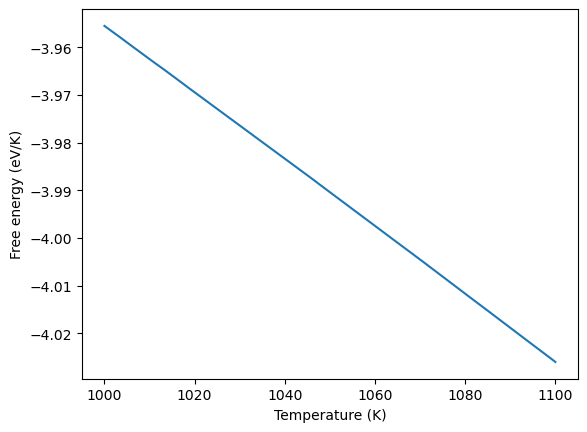

{'step1__elements': ['Cu', 'Ag', 'Au'],
 'step5__results': {'input': {'temperature': 1000,
   'pressure': 0.0,
   'lattice': 'temp.struct.dat',
   'element': 'Cu Ag Au',
   'concentration': '1.0 0.0 0.0'},
  'average': {'vol_atom': 12.324074778278732,
   'spring_constant': '2.5851999786 0.25851999786 0.25851999786',
   'density': 0.08108669954527715},
  'results': {'free_energy': -3.955491286923338,
   'error': 0.0,
   'reference_system': -0.5152399658255806,
   'work': -3.440251321097757,
   'pv': 0.0,
   'unit': 'eV/atom'}}}

In [9]:
wf.run()

In [10]:
wf.outputs